# Cells in a cylindrical geometry

This demo shows cell arangement in a cylindrical geometry. The representation deals with cells in 
the x-y  plane at a given z slice. 

Import modules and load parfis lib

In [1]:
import parfis as pfs
from parfis import Parfis
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Parfis.load_lib()

Successfully loaded lib file: libparfis64.so


Create simulation data

In [2]:
id = Parfis.newParfis()
Parfis.loadCfgData(id)
Parfis.loadSimData(id)
success = Parfis.runCommandChain(id, "create")
print("success") if success == 0 else print("fail")

success


Get pointers to configuration and simulation data

In [3]:
Parfis.setPyCfgData(id)
ptrCfgData = Parfis.getPyCfgData(id)
Parfis.setPySimData(id)
ptrSimData = Parfis.getPySimData(id)

Get geometry and cell measures

In [4]:
cellSize = ptrCfgData[0].cellSize[0]
geoSize = ptrCfgData[0].geometrySize[0]
cellCount = ptrCfgData[0].cellCount[0]
print(f"cellSize = {cellSize} meters")
print(f"geoSize = {geoSize} meters")
print(f"cellCount = {cellCount}")

cellSize = {x: 0.001, y: 0.001, z: 0.001} meters
geoSize = {x: 0.02, y: 0.02, z: 0.4} meters
cellCount = {x: 20, y: 20, z: 400}


#### Get all cells in the x-y plane at z=10
 
Every absolute id by value is `Const.noCellId` or a certain id that corresponds to the position in
the vector of existing cells. We gather two vectors, one with absolute cell ids and one with
real cell ids.

Absolute id values $A_{id}$ are calculated according to the following formula:

$$
A_{id} = C_z C_y x + C_z y + z,
$$

where $C_x$, $C_y$ and $C_z$ are number of cells in the given direction and $x$, $y$ and $z$ are
the components of the cell position vector. If geometry is cylindrical, then there are cells that
lie outside the geometry. Cell outside of the geometry have real id that is equal to 
`Const.noCellIc` (the maximum `uint32` number).

In [5]:
cellPos = pfs.Vec3DClass(pfs.Type.cellPos_t)(z=10)
absCellId = []     # Absolute cell ids
realCellId = []    # Real cell ids
boundCellId = []   # Cell ids that lie on the boundary
print(f"Cell pos               Abs. id    Rel. id      Cell pos from data")
print(f"-----------------------------------------------------------------")
for i in range(cellCount.x):
    cellPos.x = i
    for j in range(cellCount.y):
        cellPos.y = j
        absCellId.append(pfs.getAbsoluteCellId(cellCount, cellPos))
        cellId = ptrSimData[0].cellIdVec.ptr[absCellId[-1]]
        cellPosFromData = None
        if cellId != pfs.Const.noCellId:
            realCellId.append(cellId)
            cellPosFromData = ptrSimData[0].cellVec.ptr[cellId].pos
            nodeFlag = ptrSimData[0].nodeFlagVec.ptr[cellId]
            if nodeFlag != 0xFF:
                boundCellId.append(cellId)
        if i==0 and j < 10:
            print(f"{cellPos}    {absCellId[-1]:7}    {cellId:10}    {cellPosFromData}")

Cell pos               Abs. id    Rel. id      Cell pos from data
-----------------------------------------------------------------
{x: 0, y: 0, z: 10}         10    4294967295    None
{x: 0, y: 1, z: 10}        410    4294967295    None
{x: 0, y: 2, z: 10}        810    4294967295    None
{x: 0, y: 3, z: 10}       1210    4294967295    None
{x: 0, y: 4, z: 10}       1610    4294967295    None
{x: 0, y: 5, z: 10}       2010            10    {x: 0, y: 5, z: 10}
{x: 0, y: 6, z: 10}       2410           410    {x: 0, y: 6, z: 10}
{x: 0, y: 7, z: 10}       2810           810    {x: 0, y: 7, z: 10}
{x: 0, y: 8, z: 10}       3210          1210    {x: 0, y: 8, z: 10}
{x: 0, y: 9, z: 10}       3610          1610    {x: 0, y: 9, z: 10}


#### Draw all cells that exist in the simulation. 

Draw only cells that have relative id, because they exist in the `cellVec` vector.

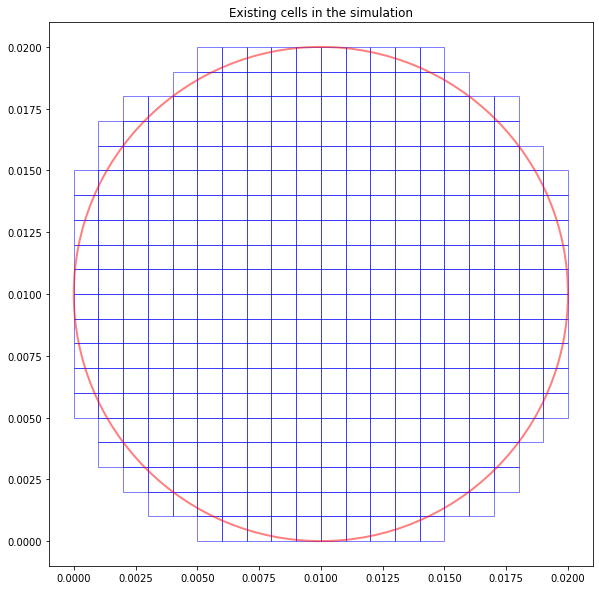

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Existing cells in the simulation")
ax.plot()
for cellId in realCellId:
    pos = ptrSimData[0].cellVec.ptr[cellId].pos
    ax.add_patch(
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
ax.add_patch(
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)
ax.set_xlim(0 - cellSize.x, geoSize.x + cellSize.x)
ax.set_ylim(0 - cellSize.y, geoSize.y + cellSize.y)
ax.set_aspect('equal')
plt.show()

#### Represent cells that are not fully inside the geometry

These cells have `nodeFlag` that is different than `uint8` max, which means that the cell has some 
nodes outside the boundary. Cells on the boundary are important for the interaction of particles 
and walls since for particles in these cells that interaction can occur.

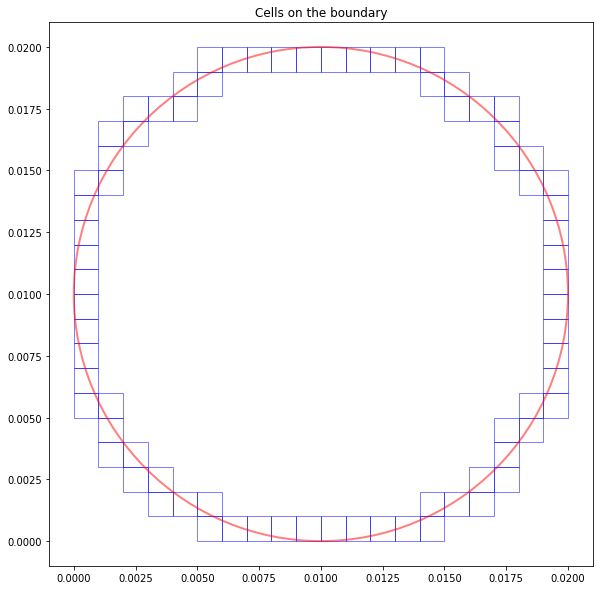

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title("Cells on the boundary")
ax.plot()
for cellId in boundCellId:
    pos = ptrSimData[0].cellVec.ptr[cellId].pos
    ax.add_patch(
        patches.Rectangle(
            (cellSize.x*pos.x, cellSize.y*pos.y),
            cellSize.x, cellSize.y,
            edgecolor = 'blue',
            alpha = 0.5,
            fill=False
        ) 
    )
# Draw the geometry bound
ax.add_patch(
patches.Circle(
    (geoSize.x*0.5, geoSize.y*0.5),
    radius=geoSize.x*0.5,
    lw = 2,
    edgecolor = 'red',
    alpha = 0.5,
    fill=False
    ) 
)
ax.set_xlim(0 - cellSize.x, geoSize.x + cellSize.x)
ax.set_ylim(0 - cellSize.y, geoSize.y + cellSize.y)
ax.set_aspect('equal')
plt.show()